In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import gc
import random
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
# from torchinfo import summary
from tqdm.notebook import tqdm
from pylops.signalprocessing import NonStationaryConvolve2D
import yaml

from unet import *

from deepinvhessian import fwi_born
from deepinvhessian.prepare_data import prepare_data
from deepinvhessian.train import train
import warnings
warnings.filterwarnings('ignore')

In [2]:
# https://github.com/swag-kaust/Transform2022_SelfSupervisedDenoising/blob/main/tutorial_utils.py
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    
    Parameters
    ----------
    seed: int 
        Integer to be used for the seed
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    return True

set_seed(14)

True

In [3]:
# https://stackoverflow.com/questions/48152674/how-do-i-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
# Define the model and acquisition parameters

par = {

        # model parameters
        'nx':500,   'dx':5.,        'ox':0,
        'nz':251,   'dz':5.,        'oz':0,
        'nr':250,   'dr':10,       'orec':0,  'rz':0,
        'ns':25,    'ds':100,       'osou':50,  'sz':0,
        'nt':500,   'dt':0.004,     'ot':0,

        # Inversion parameters
        'FWI_itr': 100, 'num_dims':2,
        'batch_size':1,
        'fwi_pass': 1,   # This is a count in case the code stopped and you want to resume 
        'freq' : 5,       # Dominant frequency


       # Input files 
        'vel_true': '../data/SEAM_Vp_Elastic_N23900_chop.bin',
   
         

#         # others parameters 
        'vel_true_path':'',


    }



num_sources_per_shot=1    
fs = 1/par['dt'] # sampling frequency

 
par ['num_batches'] = par['ns']//par ['batch_size'] 


# declare all the par in local variables
for k in par:
    locals()[k] = par[k]


exp_name = 'Exp-FWI-PSF'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

# Save the parametrs of this experiment (P.S. I save the parameter in the vel_path which is the main output)
with open(f'{exp_name}/parameters.yml', 'w') as outfile:
    yaml.dump(par, outfile, default_flow_style=False)

In [5]:
# ----------------------- input files ---------------------------------

Fvel =  par['vel_true_path'] +   par['vel_true']
    
# Load the true model
model_true = (np.fromfile(Fvel, np.float32).reshape(nx, nz))
model_true = np.transpose(model_true)

Text(0.5, 1.0, 'True Model')

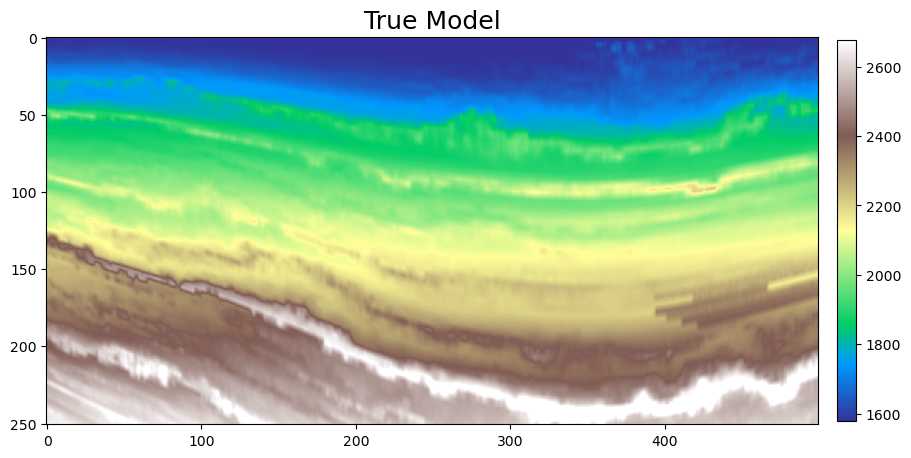

In [6]:
plt.figure(figsize=(12,8))
dm_vmin, dm_vmax = np.percentile(model_true, [2,98])
plt.imshow(model_true, vmin=dm_vmin, vmax=dm_vmax, cmap='terrain')
plt.colorbar(shrink=0.62, pad=0.02)
plt.title('True Model', fontsize=18)

In [7]:
model_true = torch.tensor(model_true, dtype=torch.float32)
# initiate the fwi class
params = fwi_born.FWIParams(par, acquisition=1)
# Create the source wavelet
wavel = fwi_born.Ricker(params).repeat(1,ns,1)
# Compute the true data
data_true = fwi_born.forward_modelling(params, model_true, wavel, device).cpu()

Text(0, 0.5, 'Time (ms)')

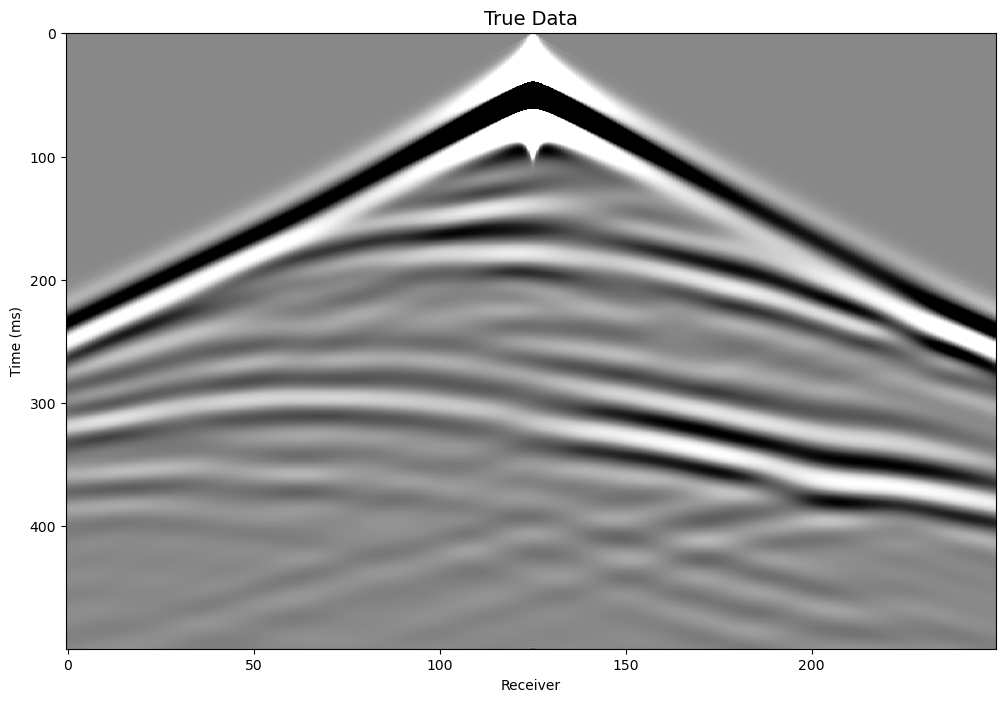

In [8]:
data_true = data_true.detach()
plt.figure(figsize=(12,8))
vmin, vmax = np.percentile(data_true[:, 12], [2,98])
plt.imshow(data_true[:, 12], aspect='auto', vmin=vmin, vmax=vmax, cmap= 'Greys')
plt.title('True Data', fontsize=14)
plt.xlabel('Receiver')
plt.ylabel('Time (ms)')

In [9]:
# Create initial guess model for inversion by smoothing the true model
model_init = gaussian_filter(model_true.cpu().detach(), sigma=15)
model_init = torch.tensor(model_init)
# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone().to(device)
model.requires_grad = True

scatter = torch.zeros_like(model)
scatter.requuires_grad = True

msk = torch.ones_like(model)
msk[:20] = 0
msk = msk.to(device)

depth = torch.tensor(list(range(0, 251))*500).reshape(500, 251).T /251
depth = depth.to(device)

In [10]:
optimizer_fwi = torch.optim.SGD([{'params': [model], 'lr': 1e2,}])
optimizer_dm1 = torch.optim.SGD([{'params': [scatter], 'lr': 1,}])
network = UNet(n_channels=2, n_classes=1, hidden_channels=64).to(device)
optimizer_unet = torch.optim.Adam(network.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

In [11]:
# Parameters to construct the reflectivity model for PSFs
start_location = (50, 40)
end_location = (-29, -39)
spacing = (70, 70)
size = (nz, nx)
# construct the reflectivity model to obtain the PSFs
scattering_model, cord = fwi_born.create_scattering_model(start_location, end_location, spacing, size)
scattering_model = torch.tensor(scattering_model).float()
scattering_model.requires_grad = True

In [12]:
gradients, dm1s, gradients_network, dms, updates = [], [], [], [], []
data_loss, vel_loss, network_loss = [], [], []
for itr in tqdm(range(FWI_itr)):
    # compute the velocity difference
    vel_loss.append(loss_fn(model, model_true.to(device)).item())
    print(f'Iteration {itr}: velocity loss = {vel_loss[-1]}')
    # compute the FWI gradient and the data misfit
    grad, loss = fwi_born.compute_gradient(params, model, data_true, wavel, optimizer_fwi, device)
    print(f'Iteration {itr}: data loss = {loss}')
    data_loss.append(loss)
    # Normalize by the maximum of the first gradient and mask the shallow part
    if itr == 0: gmax = (torch.abs(grad.detach())).max()
    grad = (grad / gmax) * msk
    gradients.append(grad.detach().cpu().numpy())
    
    if itr % 10 == 0:
        # Run Born modeling and its adjoint to obtain the PSFs for the current background model -> the migrated image
        scatterers = fwi_born.compute_dm1(params, model, scattering_model, wavel, optimizer_dm1, device)
        # Extract the PSFs from the migrated image
        psfs = fwi_born.create_psfs(scatterers.detach().cpu().numpy(), 
                                    psfs_locations_z=np.unique(cord[1]), psfs_locations_x=np.unique(cord[0]),
                                    psfs_location_init=(15, 3), psfsize=(71, 71))
        # Construct the Hessian using the extracted PSFs
        Cop = NonStationaryConvolve2D(hs=psfs, ihx=np.unique(cord[1]), ihz=np.unique(cord[0]),
                                      dims=(nz, nx), engine="numba")
        
    # compute the remigrated image by applying the Hessian to the gradient
    dm1 = Cop * grad.detach().clone().cpu().numpy().ravel()
    dm1 = dm1.reshape(nz, nx)
    dm1 = torch.tensor(dm1).float().to(device)
    # Normalize by the maximum and mask the shallow part
    if itr == 0 : dmmax =  1e1* torch.abs(dm1.detach()).max()
    dm1 = (dm1 / dmmax) * msk
    dm1s.append(dm1.detach().cpu().numpy())
    
    
    gc.collect()
    torch.cuda.empty_cache()
    # create training data for the network to learn the inverse of the Hessian
    train_dataloader = prepare_data(dm1.detach(), depth, grad.detach(), patch_size=32, slide=8, batch_size=64)
    # train the network
    network_iter = 30 if itr == 0 else 5
    loss = train(network, train_dataloader, optimizer_unet, loss_fn, network_iter, device)
    network_loss.extend(loss)
    del train_dataloader
    gc.collect()
    torch.cuda.empty_cache()
    # Obtain the fitted gradient by the network
    with torch.no_grad():
        inp = torch.cat([dm1.detach().unsqueeze(0), depth.unsqueeze(0)])
        g = network(inp.unsqueeze(0)).squeeze() * msk
    gradients_network.append(g.detach().cpu().numpy())
    
    # Apply the network to the FWI gradient to get the Hessian corrected update 
    with torch.no_grad():
        inp = torch.cat([grad.unsqueeze(0), depth.unsqueeze(0)])
        dm = network(inp.unsqueeze(0)).squeeze() * msk
    dms.append(dm.detach().cpu().numpy())
    
    # Update the model
    model.grad.data[:] = dm.data[:].detach().clone()
    optimizer_fwi.step()
    updates.append(model.detach().cpu().numpy())
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0: velocity loss = 2141.5458984375
Iteration 0: data loss = 1.1411731833277372e-05


  0%|          | 0/30 [00:00<?, ?it/s]

Training Epoch 0, Loss = 0.015567795592634118
Training Epoch 1, Loss = 0.0002241143400383675
Training Epoch 2, Loss = 0.0001733186507800722
Training Epoch 3, Loss = 0.00014262524856866208
Training Epoch 4, Loss = 0.00014797752010053955
Training Epoch 5, Loss = 0.00012390373676145615
Training Epoch 6, Loss = 0.00012910439966385727
Training Epoch 7, Loss = 0.00010737466158495997
Training Epoch 8, Loss = 9.914221949407411e-05
Training Epoch 9, Loss = 0.00010881526039013931
Training Epoch 10, Loss = 9.347134176755836e-05
Training Epoch 11, Loss = 8.774470659452217e-05
Training Epoch 12, Loss = 9.468539542913455e-05
Training Epoch 13, Loss = 8.085491483107748e-05
Training Epoch 14, Loss = 8.21424388656548e-05
Training Epoch 15, Loss = 7.825774210847586e-05
Training Epoch 16, Loss = 8.42781667183861e-05
Training Epoch 17, Loss = 8.994953025773844e-05
Training Epoch 18, Loss = 6.717318291182393e-05
Training Epoch 19, Loss = 7.065931002252197e-05
Training Epoch 20, Loss = 7.22305254634657e-05


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.935088589773217e-05
Training Epoch 1, Loss = 3.540664828523957e-05
Training Epoch 2, Loss = 3.9607237073034735e-05
Training Epoch 3, Loss = 4.2072226938662604e-05
Training Epoch 4, Loss = 3.3095609176277375e-05
Iteration 2: velocity loss = 1731.7757568359375
Iteration 2: data loss = 7.084432809278951e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.5975010154141665e-05
Training Epoch 1, Loss = 2.673522576336765e-05
Training Epoch 2, Loss = 2.5241331201744058e-05
Training Epoch 3, Loss = 2.6069670104120366e-05
Training Epoch 4, Loss = 2.2878436663863705e-05
Iteration 3: velocity loss = 1586.8992919921875
Iteration 3: data loss = 5.774301826022565e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.1856296121304874e-05
Training Epoch 1, Loss = 1.6080813236162522e-05
Training Epoch 2, Loss = 1.5634801296554916e-05
Training Epoch 3, Loss = 1.9462376106578933e-05
Training Epoch 4, Loss = 2.3414928952714783e-05
Iteration 4: velocity loss = 1460.290283203125
Iteration 4: data loss = 4.695447742619763e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2694865014126145e-05
Training Epoch 1, Loss = 1.1079760337024173e-05
Training Epoch 2, Loss = 1.5005769103249894e-05
Training Epoch 3, Loss = 1.4291047395375904e-05
Training Epoch 4, Loss = 1.091632555685732e-05
Iteration 5: velocity loss = 1358.835205078125
Iteration 5: data loss = 3.909101224053302e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1074450336915712e-05
Training Epoch 1, Loss = 9.9098600083594e-06
Training Epoch 2, Loss = 1.0801759612256907e-05
Training Epoch 3, Loss = 9.68987000323621e-06
Training Epoch 4, Loss = 9.609938575415393e-06
Iteration 6: velocity loss = 1273.09912109375
Iteration 6: data loss = 3.2980125936887816e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.577606574059852e-06
Training Epoch 1, Loss = 8.023721483029886e-06
Training Epoch 2, Loss = 6.964107525146021e-06
Training Epoch 3, Loss = 9.404609283824267e-06
Training Epoch 4, Loss = 8.050645054062639e-06
Iteration 7: velocity loss = 1204.291015625
Iteration 7: data loss = 2.8273977861204003e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0622324885380472e-05
Training Epoch 1, Loss = 6.128458677249357e-06
Training Epoch 2, Loss = 6.034216031527167e-06
Training Epoch 3, Loss = 5.514115545623759e-06
Training Epoch 4, Loss = 7.131648223602336e-06
Iteration 8: velocity loss = 1149.3309326171875
Iteration 8: data loss = 2.4962141083051392e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 4.255387836440373e-06
Training Epoch 1, Loss = 4.864452838167684e-06
Training Epoch 2, Loss = 5.795519900500806e-06
Training Epoch 3, Loss = 4.948914222807741e-06
Training Epoch 4, Loss = 4.559978456913371e-06
Iteration 9: velocity loss = 1104.2645263671875
Iteration 9: data loss = 2.2550812204258364e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.725113307231154e-06
Training Epoch 1, Loss = 5.852547529934336e-06
Training Epoch 2, Loss = 4.936022466439431e-06
Training Epoch 3, Loss = 3.6146034234412117e-06
Training Epoch 4, Loss = 6.357580450550777e-06
Iteration 10: velocity loss = 1069.347412109375
Iteration 10: data loss = 2.071283727644868e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.751130901462245e-06
Training Epoch 1, Loss = 3.3784210700105177e-06
Training Epoch 2, Loss = 4.8852100328932625e-06
Training Epoch 3, Loss = 3.8396530022046316e-06
Training Epoch 4, Loss = 6.261814034507338e-06
Iteration 11: velocity loss = 1049.88232421875
Iteration 11: data loss = 1.981993641209101e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.7240225687324425e-06
Training Epoch 1, Loss = 2.8840915132712005e-06
Training Epoch 2, Loss = 3.1807596702920444e-06
Training Epoch 3, Loss = 3.4249761443681884e-06
Training Epoch 4, Loss = 5.348294983636436e-06
Iteration 12: velocity loss = 1032.0050048828125
Iteration 12: data loss = 1.9008689839949966e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.063655791314815e-06
Training Epoch 1, Loss = 2.9244224951891703e-06
Training Epoch 2, Loss = 5.2194780461796455e-06
Training Epoch 3, Loss = 2.4544931476406883e-06
Training Epoch 4, Loss = 3.3066021432222996e-06
Iteration 13: velocity loss = 1016.4545288085938
Iteration 13: data loss = 1.8339403524691988e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.0197918855871344e-06
Training Epoch 1, Loss = 2.250710626778492e-06
Training Epoch 2, Loss = 3.2400291328325264e-06
Training Epoch 3, Loss = 4.806294944224717e-06
Training Epoch 4, Loss = 2.7359693459117147e-06
Iteration 14: velocity loss = 1002.82275390625
Iteration 14: data loss = 1.7783498229562156e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.2159553132755094e-06
Training Epoch 1, Loss = 2.100537225081936e-06
Training Epoch 2, Loss = 3.141496275769468e-06
Training Epoch 3, Loss = 1.88133128296934e-06
Training Epoch 4, Loss = 2.7493144168423826e-06
Iteration 15: velocity loss = 991.5791625976562
Iteration 15: data loss = 1.7295966401320584e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.573627135822843e-06
Training Epoch 1, Loss = 3.323447585631477e-06
Training Epoch 2, Loss = 2.834971002910464e-06
Training Epoch 3, Loss = 1.8746731648340808e-06
Training Epoch 4, Loss = 2.8935396067160637e-06
Iteration 16: velocity loss = 980.6067504882812
Iteration 16: data loss = 1.686242509180147e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.7385432376519805e-06
Training Epoch 1, Loss = 1.4023874290855661e-06
Training Epoch 2, Loss = 2.535203580522398e-06
Training Epoch 3, Loss = 3.253863166951216e-06
Training Epoch 4, Loss = 2.9047861373248237e-06
Iteration 17: velocity loss = 969.2101440429688
Iteration 17: data loss = 1.6509554541244142e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.220201352264328e-06
Training Epoch 1, Loss = 2.290108028546456e-06
Training Epoch 2, Loss = 1.5098097260952985e-06
Training Epoch 3, Loss = 2.8533067153620877e-06
Training Epoch 4, Loss = 1.0950478307828841e-06
Iteration 18: velocity loss = 960.568359375
Iteration 18: data loss = 1.6201144816818669e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.1169741491651925e-06
Training Epoch 1, Loss = 2.5394692784175277e-06
Training Epoch 2, Loss = 2.3130524644053437e-06
Training Epoch 3, Loss = 1.6898431629962105e-05
Training Epoch 4, Loss = 3.629216999846832e-06
Iteration 19: velocity loss = 952.2808837890625
Iteration 19: data loss = 1.5953897509746184e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0770545990939639e-06
Training Epoch 1, Loss = 1.3254951310317683e-06
Training Epoch 2, Loss = 1.5156177528520037e-06
Training Epoch 3, Loss = 1.4459591267602853e-06
Training Epoch 4, Loss = 1.9328042370426714e-06
Iteration 20: velocity loss = 944.136962890625
Iteration 20: data loss = 1.5699162592142102e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1770956558398121e-06
Training Epoch 1, Loss = 1.2885524812384789e-06
Training Epoch 2, Loss = 7.88751779010436e-07
Training Epoch 3, Loss = 1.0358413200996366e-06
Training Epoch 4, Loss = 1.261276007452954e-06
Iteration 21: velocity loss = 938.4476928710938
Iteration 21: data loss = 1.5520554583758894e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.8219964708381952e-06
Training Epoch 1, Loss = 1.1513991829164582e-06
Training Epoch 2, Loss = 1.04314975982668e-06
Training Epoch 3, Loss = 1.1861544576878954e-06
Training Epoch 4, Loss = 1.4784154166860907e-06
Iteration 22: velocity loss = 933.08203125
Iteration 22: data loss = 1.5367691297285546e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.136578361535844e-06
Training Epoch 1, Loss = 2.479204917839453e-06
Training Epoch 2, Loss = 1.2473427583015609e-06
Training Epoch 3, Loss = 1.1384384623847926e-06
Training Epoch 4, Loss = 1.271854446353397e-06
Iteration 23: velocity loss = 927.0452880859375
Iteration 23: data loss = 1.5224113685263774e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5509663057298217e-06
Training Epoch 1, Loss = 1.1251909704273488e-06
Training Epoch 2, Loss = 1.4079026832561402e-06
Training Epoch 3, Loss = 1.7804151245765717e-06
Training Epoch 4, Loss = 1.2462814611598885e-06
Iteration 24: velocity loss = 922.929931640625
Iteration 24: data loss = 1.5092380660775007e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0710305378093016e-06
Training Epoch 1, Loss = 1.573149139669924e-06
Training Epoch 2, Loss = 1.0052864631543968e-06
Training Epoch 3, Loss = 1.4201297614470284e-06
Training Epoch 4, Loss = 1.255959795807761e-06
Iteration 25: velocity loss = 917.8751220703125
Iteration 25: data loss = 1.4976597171312278e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2372474252091991e-06
Training Epoch 1, Loss = 1.0772422863104949e-06
Training Epoch 2, Loss = 1.1114025435390698e-06
Training Epoch 3, Loss = 1.1881105635882472e-06
Training Epoch 4, Loss = 9.277119554654104e-07
Iteration 26: velocity loss = 913.760009765625
Iteration 26: data loss = 1.4872814873001516e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.2318766491591804e-06
Training Epoch 1, Loss = 2.1596254585427447e-06
Training Epoch 2, Loss = 8.784480816833214e-07
Training Epoch 3, Loss = 8.134529520912467e-07
Training Epoch 4, Loss = 1.8449568434740358e-06
Iteration 27: velocity loss = 908.6634521484375
Iteration 27: data loss = 1.4768090323968863e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.45613850465862e-06
Training Epoch 1, Loss = 9.23318565377949e-07
Training Epoch 2, Loss = 1.1538128673321932e-06
Training Epoch 3, Loss = 1.5232175295902077e-06
Training Epoch 4, Loss = 1.6844886879002218e-06
Iteration 28: velocity loss = 904.6039428710938
Iteration 28: data loss = 1.4672847790109245e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5104099495479382e-06
Training Epoch 1, Loss = 1.0078646103490393e-06
Training Epoch 2, Loss = 1.9784983960874467e-06
Training Epoch 3, Loss = 5.168264519228365e-05
Training Epoch 4, Loss = 3.7524512476118296e-06
Iteration 29: velocity loss = 905.1162109375
Iteration 29: data loss = 1.4674947586001963e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.150148764760553e-06
Training Epoch 1, Loss = 3.275517058807286e-06
Training Epoch 2, Loss = 2.9598602429145743e-06
Training Epoch 3, Loss = 2.4914298039363405e-06
Training Epoch 4, Loss = 1.8487124527703547e-06
Iteration 30: velocity loss = 901.9808349609375
Iteration 30: data loss = 1.4586306136266103e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.5294609902933494e-06
Training Epoch 1, Loss = 1.422971278690752e-06
Training Epoch 2, Loss = 1.8129444013128722e-06
Training Epoch 3, Loss = 1.5286881441223908e-06
Training Epoch 4, Loss = 2.443776928791575e-06
Iteration 31: velocity loss = 898.6544189453125
Iteration 31: data loss = 1.4506412533421553e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.7709805955318563e-06
Training Epoch 1, Loss = 1.3785391856532335e-06
Training Epoch 2, Loss = 1.6566983519766711e-06
Training Epoch 3, Loss = 2.0031835429465135e-06
Training Epoch 4, Loss = 1.6614551006622445e-06
Iteration 32: velocity loss = 895.0846557617188
Iteration 32: data loss = 1.4428128221055658e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.7005287028112826e-06
Training Epoch 1, Loss = 1.8996405554291556e-06
Training Epoch 2, Loss = 2.1663924970278673e-06
Training Epoch 3, Loss = 1.961860389245903e-06
Training Epoch 4, Loss = 2.314725917380665e-06
Iteration 33: velocity loss = 891.7974243164062
Iteration 33: data loss = 1.435356267620591e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.3775780929928955e-06
Training Epoch 1, Loss = 2.8244919793879115e-06
Training Epoch 2, Loss = 2.1914345442088663e-06
Training Epoch 3, Loss = 1.992914487310176e-06
Training Epoch 4, Loss = 2.8657169037597114e-06
Iteration 34: velocity loss = 888.5078125
Iteration 34: data loss = 1.4287759810827083e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.187181915841767e-06
Training Epoch 1, Loss = 1.5125792224486811e-06
Training Epoch 2, Loss = 2.148781945544554e-06
Training Epoch 3, Loss = 1.7500929663369521e-06
Training Epoch 4, Loss = 1.6803625085543115e-06
Iteration 35: velocity loss = 885.6541748046875
Iteration 35: data loss = 1.422156689301346e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.5919239200064506e-06
Training Epoch 1, Loss = 1.3170824451984065e-06
Training Epoch 2, Loss = 1.6481176500934345e-06
Training Epoch 3, Loss = 2.487540071757287e-06
Training Epoch 4, Loss = 2.138485485250153e-06
Iteration 36: velocity loss = 883.0281372070312
Iteration 36: data loss = 1.4167808757292732e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.9525419361343666e-06
Training Epoch 1, Loss = 2.5220414423021044e-06
Training Epoch 2, Loss = 2.6072488277109457e-06
Training Epoch 3, Loss = 1.838231658185203e-06
Training Epoch 4, Loss = 1.564976439366921e-06
Iteration 37: velocity loss = 880.4969482421875
Iteration 37: data loss = 1.4110789994248307e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5868179089323473e-06
Training Epoch 1, Loss = 1.5595914065028517e-06
Training Epoch 2, Loss = 1.4863671755365965e-06
Training Epoch 3, Loss = 1.2284449584798245e-06
Training Epoch 4, Loss = 1.961701957720923e-06
Iteration 38: velocity loss = 877.8406982421875
Iteration 38: data loss = 1.4063461222235674e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.0057331787082898e-06
Training Epoch 1, Loss = 2.6412434230152545e-06
Training Epoch 2, Loss = 2.6180777804345815e-06
Training Epoch 3, Loss = 1.3328969809360085e-06
Training Epoch 4, Loss = 1.5207770114583956e-06
Iteration 39: velocity loss = 875.3535766601562
Iteration 39: data loss = 1.4014029385833737e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.3016188562705436e-06
Training Epoch 1, Loss = 1.4224829937227376e-06
Training Epoch 2, Loss = 1.8271074278639871e-06
Training Epoch 3, Loss = 1.2997039569725922e-06
Training Epoch 4, Loss = 1.4361401383666816e-06
Iteration 40: velocity loss = 873.4677734375
Iteration 40: data loss = 1.3973472334782855e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 2.4432435290967917e-06
Training Epoch 1, Loss = 1.755769381352544e-06
Training Epoch 2, Loss = 1.5197303151340106e-06
Training Epoch 3, Loss = 2.9091379106456076e-06
Training Epoch 4, Loss = 1.0272679610486246e-06
Iteration 41: velocity loss = 872.1024169921875
Iteration 41: data loss = 1.3936580831597212e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.4675951547360455e-06
Training Epoch 1, Loss = 1.2759137612593964e-06
Training Epoch 2, Loss = 1.3371150652230926e-06
Training Epoch 3, Loss = 2.462390537014953e-06
Training Epoch 4, Loss = 1.2446087602452905e-06
Iteration 42: velocity loss = 870.2951049804688
Iteration 42: data loss = 1.3900490500873275e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.225351614859356e-06
Training Epoch 1, Loss = 1.4455828428325214e-06
Training Epoch 2, Loss = 1.467790819814956e-06
Training Epoch 3, Loss = 1.921183373015618e-06
Training Epoch 4, Loss = 1.8978703633142596e-06
Iteration 43: velocity loss = 868.7041625976562
Iteration 43: data loss = 1.3868121282456514e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.114963199553113e-06
Training Epoch 1, Loss = 1.4457839197392804e-06
Training Epoch 2, Loss = 1.8307670311336479e-06
Training Epoch 3, Loss = 1.51366142445425e-06
Training Epoch 4, Loss = 2.684062636427709e-06
Iteration 44: velocity loss = 867.7514038085938
Iteration 44: data loss = 1.3842968176192016e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.8659045408372442e-06
Training Epoch 1, Loss = 1.7531016578463915e-06
Training Epoch 2, Loss = 1.8615825863479603e-06
Training Epoch 3, Loss = 1.1905047199211277e-06
Training Epoch 4, Loss = 1.3517313595243382e-06
Iteration 45: velocity loss = 866.58935546875
Iteration 45: data loss = 1.3816587856041451e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.641322420058999e-06
Training Epoch 1, Loss = 1.925249156507633e-06
Training Epoch 2, Loss = 1.1009049209334597e-06
Training Epoch 3, Loss = 1.4379590352603498e-06
Training Epoch 4, Loss = 1.5300635057508986e-06
Iteration 46: velocity loss = 865.4869384765625
Iteration 46: data loss = 1.3784344652378877e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1259614414520199e-06
Training Epoch 1, Loss = 1.671911745710995e-06
Training Epoch 2, Loss = 1.4889145944050374e-06
Training Epoch 3, Loss = 1.2888352419988188e-06
Training Epoch 4, Loss = 1.3860295181904588e-06
Iteration 47: velocity loss = 863.9442138671875
Iteration 47: data loss = 1.3752718910353678e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.7003485448399528e-06
Training Epoch 1, Loss = 2.5837307826831795e-06
Training Epoch 2, Loss = 9.92489419764288e-07
Training Epoch 3, Loss = 1.145830218681166e-06
Training Epoch 4, Loss = 1.0984628201025344e-06
Iteration 48: velocity loss = 862.56689453125
Iteration 48: data loss = 1.3719769835773832e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0224045022190622e-06
Training Epoch 1, Loss = 1.979665199212154e-06
Training Epoch 2, Loss = 1.5528284339940428e-06
Training Epoch 3, Loss = 8.161662233372707e-07
Training Epoch 4, Loss = 1.1882078590409874e-06
Iteration 49: velocity loss = 861.2628173828125
Iteration 49: data loss = 1.3694330842639602e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.4589477376268725e-06
Training Epoch 1, Loss = 1.1570252001110573e-06
Training Epoch 2, Loss = 1.5290080382640678e-06
Training Epoch 3, Loss = 1.7980774671019282e-06
Training Epoch 4, Loss = 1.4017096897394402e-06
Iteration 50: velocity loss = 859.724365234375
Iteration 50: data loss = 1.366454011275664e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5062281730193967e-06
Training Epoch 1, Loss = 1.539680527248136e-06
Training Epoch 2, Loss = 1.4526298502023207e-06
Training Epoch 3, Loss = 1.1407331189105867e-06
Training Epoch 4, Loss = 8.919483956132728e-07
Iteration 51: velocity loss = 858.7006225585938
Iteration 51: data loss = 1.3644121299449807e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1756036743646274e-06
Training Epoch 1, Loss = 1.8619664009141463e-06
Training Epoch 2, Loss = 1.2559086105382306e-06
Training Epoch 3, Loss = 1.3155428414772057e-06
Training Epoch 4, Loss = 9.665181966836684e-07
Iteration 52: velocity loss = 857.4011840820312
Iteration 52: data loss = 1.3619706553669175e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.976962574040669e-07
Training Epoch 1, Loss = 1.4549239199034084e-06
Training Epoch 2, Loss = 1.415311692923359e-06
Training Epoch 3, Loss = 1.633819096014122e-06
Training Epoch 4, Loss = 8.072001902274125e-07
Iteration 53: velocity loss = 856.271728515625
Iteration 53: data loss = 1.35963601977096e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.138822063788158e-06
Training Epoch 1, Loss = 1.4877920934805825e-06
Training Epoch 2, Loss = 1.3954408250267044e-06
Training Epoch 3, Loss = 1.1464962360226612e-06
Training Epoch 4, Loss = 1.488093090807863e-06
Iteration 54: velocity loss = 855.3433227539062
Iteration 54: data loss = 1.3578816790982273e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.317468533501347e-06
Training Epoch 1, Loss = 8.117791541543934e-07
Training Epoch 2, Loss = 1.6057468170116658e-06
Training Epoch 3, Loss = 1.5659673792635088e-06
Training Epoch 4, Loss = 1.4701700902775223e-06
Iteration 55: velocity loss = 854.1788330078125
Iteration 55: data loss = 1.3559359324233355e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.059610598743115e-07
Training Epoch 1, Loss = 9.369578525504003e-07
Training Epoch 2, Loss = 1.3535175806474202e-06
Training Epoch 3, Loss = 1.428649905026795e-06
Training Epoch 4, Loss = 1.0888812282166113e-06
Iteration 56: velocity loss = 853.052490234375
Iteration 56: data loss = 1.3537142748987208e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.541277795831329e-06
Training Epoch 1, Loss = 8.718505068047449e-07
Training Epoch 2, Loss = 1.0089279154008894e-06
Training Epoch 3, Loss = 1.2498339937199524e-06
Training Epoch 4, Loss = 1.2113080940730025e-06
Iteration 57: velocity loss = 851.6915893554688
Iteration 57: data loss = 1.3514746939335964e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.891205352078531e-06
Training Epoch 1, Loss = 1.1437787101581932e-06
Training Epoch 2, Loss = 2.0202556992016445e-06
Training Epoch 3, Loss = 9.66429354599652e-07
Training Epoch 4, Loss = 1.0604413500691318e-06
Iteration 58: velocity loss = 850.794921875
Iteration 58: data loss = 1.349222239710457e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.552853922973162e-06
Training Epoch 1, Loss = 8.524867827948887e-07
Training Epoch 2, Loss = 8.621621334419151e-07
Training Epoch 3, Loss = 1.3864648947531475e-06
Training Epoch 4, Loss = 1.0458652359843387e-06
Iteration 59: velocity loss = 849.8904418945312
Iteration 59: data loss = 1.3475804134799318e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.915041692251822e-07
Training Epoch 1, Loss = 1.9001032895590362e-06
Training Epoch 2, Loss = 1.04218929914837e-06
Training Epoch 3, Loss = 1.1669601122981011e-06
Training Epoch 4, Loss = 1.2999833752563098e-06
Iteration 60: velocity loss = 849.0502319335938
Iteration 60: data loss = 1.3457429144381194e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.42004160582363e-07
Training Epoch 1, Loss = 9.969689874005068e-07
Training Epoch 2, Loss = 1.422443782909492e-06
Training Epoch 3, Loss = 1.2219890114871377e-06
Training Epoch 4, Loss = 1.1586654626599364e-06
Iteration 61: velocity loss = 848.3112182617188
Iteration 61: data loss = 1.3440258861407983e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.272006063114495e-07
Training Epoch 1, Loss = 1.0999410892174957e-06
Training Epoch 2, Loss = 1.4912399118251342e-06
Training Epoch 3, Loss = 1.2339921229853394e-06
Training Epoch 4, Loss = 8.523383470736578e-07
Iteration 62: velocity loss = 847.5978393554688
Iteration 62: data loss = 1.342210884658357e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.4330675581981732e-06
Training Epoch 1, Loss = 1.6485456576313429e-06
Training Epoch 2, Loss = 7.938652162483421e-07
Training Epoch 3, Loss = 8.912048524864219e-07
Training Epoch 4, Loss = 1.1108792348050331e-06
Iteration 63: velocity loss = 846.9232177734375
Iteration 63: data loss = 1.3405987289161203e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.3396556815504322e-06
Training Epoch 1, Loss = 2.5431573198366275e-06
Training Epoch 2, Loss = 1.125986703893396e-06
Training Epoch 3, Loss = 6.611452054063621e-07
Training Epoch 4, Loss = 6.999703382840986e-07
Iteration 64: velocity loss = 846.14453125
Iteration 64: data loss = 1.3391060331713334e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.4464045122230006e-06
Training Epoch 1, Loss = 8.253699583488639e-07
Training Epoch 2, Loss = 1.031626590410198e-06
Training Epoch 3, Loss = 1.6912575955307058e-06
Training Epoch 4, Loss = 9.649700527960721e-07
Iteration 65: velocity loss = 845.142578125
Iteration 65: data loss = 1.3386798176640013e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.9158116919461643e-06
Training Epoch 1, Loss = 9.56007551501577e-07
Training Epoch 2, Loss = 9.722104735209201e-07
Training Epoch 3, Loss = 8.244286382986342e-07
Training Epoch 4, Loss = 9.513248433195793e-07
Iteration 66: velocity loss = 844.3408203125
Iteration 66: data loss = 1.3371981193444071e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2011071192978751e-06
Training Epoch 1, Loss = 1.1855872718253487e-06
Training Epoch 2, Loss = 1.21925561655626e-06
Training Epoch 3, Loss = 1.3729899218422396e-06
Training Epoch 4, Loss = 1.2921861010748698e-06
Iteration 67: velocity loss = 843.7320556640625
Iteration 67: data loss = 1.3357068677777306e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.263316643557493e-06
Training Epoch 1, Loss = 1.5497327531059402e-06
Training Epoch 2, Loss = 9.65021312742251e-07
Training Epoch 3, Loss = 8.779259233319061e-07
Training Epoch 4, Loss = 8.210360731504361e-07
Iteration 68: velocity loss = 842.7906494140625
Iteration 68: data loss = 1.3341868108085464e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.908665256435365e-07
Training Epoch 1, Loss = 1.5270028225755845e-06
Training Epoch 2, Loss = 9.407362666461624e-07
Training Epoch 3, Loss = 1.6022998070139675e-06
Training Epoch 4, Loss = 1.0894517842808794e-06
Iteration 69: velocity loss = 841.7118530273438
Iteration 69: data loss = 1.3323660414954475e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1199594816688142e-06
Training Epoch 1, Loss = 1.2626457504996092e-06
Training Epoch 2, Loss = 9.74567210583504e-07
Training Epoch 3, Loss = 1.3695691729467666e-06
Training Epoch 4, Loss = 9.519272091282284e-07
Iteration 70: velocity loss = 840.3024291992188
Iteration 70: data loss = 1.3303595611802166e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.328747937599366e-07
Training Epoch 1, Loss = 1.5339113117288792e-06
Training Epoch 2, Loss = 9.862167131051832e-07
Training Epoch 3, Loss = 1.1064612168883839e-06
Training Epoch 4, Loss = 1.0593710584316796e-06
Iteration 71: velocity loss = 839.6634521484375
Iteration 71: data loss = 1.32897107718577e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1014138785154216e-06
Training Epoch 1, Loss = 8.385388450532821e-07
Training Epoch 2, Loss = 9.399232246377163e-07
Training Epoch 3, Loss = 1.1101572439719008e-06
Training Epoch 4, Loss = 1.2685397816276948e-06
Iteration 72: velocity loss = 838.4358520507812
Iteration 72: data loss = 1.3273998540341836e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1322693244348522e-06
Training Epoch 1, Loss = 7.612733398610883e-07
Training Epoch 2, Loss = 1.2365961807477908e-06
Training Epoch 3, Loss = 1.0748224090271905e-06
Training Epoch 4, Loss = 1.5116080763222022e-06
Iteration 73: velocity loss = 836.7614135742188
Iteration 73: data loss = 1.325497596127434e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2089715968899077e-06
Training Epoch 1, Loss = 6.292937780806503e-07
Training Epoch 2, Loss = 1.2000953025411338e-06
Training Epoch 3, Loss = 1.0425900970791617e-06
Training Epoch 4, Loss = 1.6585129892362994e-06
Iteration 74: velocity loss = 836.508056640625
Iteration 74: data loss = 1.3242098262367108e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.739649276174746e-07
Training Epoch 1, Loss = 7.569761284203731e-07
Training Epoch 2, Loss = 8.204856775520574e-07
Training Epoch 3, Loss = 1.2511338397024362e-06
Training Epoch 4, Loss = 1.1116458789301225e-06
Iteration 75: velocity loss = 835.9834594726562
Iteration 75: data loss = 1.323122869933968e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.86274447434873e-07
Training Epoch 1, Loss = 9.033659410408968e-07
Training Epoch 2, Loss = 1.1680317701281156e-06
Training Epoch 3, Loss = 1.3757870906307717e-06
Training Epoch 4, Loss = 7.718579023860145e-07
Iteration 76: velocity loss = 835.1495361328125
Iteration 76: data loss = 1.3220664758506473e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.894664672441757e-07
Training Epoch 1, Loss = 9.671630705025011e-07
Training Epoch 2, Loss = 1.1939490989601944e-06
Training Epoch 3, Loss = 8.956988109815154e-07
Training Epoch 4, Loss = 9.532328470092633e-07
Iteration 77: velocity loss = 834.802734375
Iteration 77: data loss = 1.3207908988732697e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.5167865861784259e-06
Training Epoch 1, Loss = 8.962633530677968e-07
Training Epoch 2, Loss = 8.736232969982559e-07
Training Epoch 3, Loss = 1.4664426103928575e-06
Training Epoch 4, Loss = 6.519195514052697e-07
Iteration 78: velocity loss = 833.8712158203125
Iteration 78: data loss = 1.319580647418661e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2971245114352529e-06
Training Epoch 1, Loss = 1.102410822916093e-06
Training Epoch 2, Loss = 1.1142227479837732e-06
Training Epoch 3, Loss = 6.729929752652299e-07
Training Epoch 4, Loss = 1.0613902927103731e-06
Iteration 79: velocity loss = 833.018798828125
Iteration 79: data loss = 1.3185711740248962e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.449723590431912e-07
Training Epoch 1, Loss = 1.095181688953619e-06
Training Epoch 2, Loss = 1.3027482241029122e-06
Training Epoch 3, Loss = 1.8349487924760801e-06
Training Epoch 4, Loss = 7.520421742775201e-07
Iteration 80: velocity loss = 832.2069091796875
Iteration 80: data loss = 1.3173054398407658e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.044788740890837e-06
Training Epoch 1, Loss = 1.0542420856644837e-06
Training Epoch 2, Loss = 1.7691650992121282e-06
Training Epoch 3, Loss = 6.051219562728946e-07
Training Epoch 4, Loss = 1.0972977153142875e-06
Iteration 81: velocity loss = 831.4641723632812
Iteration 81: data loss = 1.3159116782901492e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.467687947057272e-07
Training Epoch 1, Loss = 8.500915644096013e-07
Training Epoch 2, Loss = 1.1932392472620752e-06
Training Epoch 3, Loss = 9.894256907291135e-07
Training Epoch 4, Loss = 1.013307475818915e-06
Iteration 82: velocity loss = 830.9589233398438
Iteration 82: data loss = 1.3146083830406496e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.292951392803932e-07
Training Epoch 1, Loss = 1.301236324721623e-06
Training Epoch 2, Loss = 9.164788263892572e-07
Training Epoch 3, Loss = 1.0857351717990526e-06
Training Epoch 4, Loss = 1.2120200498135518e-06
Iteration 83: velocity loss = 830.4573974609375
Iteration 83: data loss = 1.313651390333348e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.6173011483247405e-06
Training Epoch 1, Loss = 9.102100608738599e-07
Training Epoch 2, Loss = 9.551420285280234e-07
Training Epoch 3, Loss = 6.726006801625095e-07
Training Epoch 4, Loss = 7.722039404600264e-07
Iteration 84: velocity loss = 830.2066040039062
Iteration 84: data loss = 1.3128485729652084e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.720965636057318e-07
Training Epoch 1, Loss = 1.3386524342177284e-06
Training Epoch 2, Loss = 1.3076165750888714e-06
Training Epoch 3, Loss = 1.1075168468247891e-06
Training Epoch 4, Loss = 9.171043171595468e-07
Iteration 85: velocity loss = 829.8490600585938
Iteration 85: data loss = 1.3120221318274616e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 5.060694043518821e-07
Training Epoch 1, Loss = 9.316081774074394e-07
Training Epoch 2, Loss = 8.280624789605616e-07
Training Epoch 3, Loss = 9.778421515119697e-07
Training Epoch 4, Loss = 1.4132917136893696e-06
Iteration 86: velocity loss = 829.4545288085938
Iteration 86: data loss = 1.3110878036570739e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 9.70062036658954e-07
Training Epoch 1, Loss = 7.461854477576387e-07
Training Epoch 2, Loss = 7.351838872061896e-07
Training Epoch 3, Loss = 9.251466204708706e-07
Training Epoch 4, Loss = 6.208055192005571e-07
Iteration 87: velocity loss = 829.09814453125
Iteration 87: data loss = 1.3102253930696861e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.3726887828243782e-06
Training Epoch 1, Loss = 6.535326400134912e-07
Training Epoch 2, Loss = 9.995224407272837e-07
Training Epoch 3, Loss = 6.851120664250362e-07
Training Epoch 4, Loss = 1.238896871592599e-06
Iteration 88: velocity loss = 828.6341552734375
Iteration 88: data loss = 1.3093732533775437e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2112234694084281e-06
Training Epoch 1, Loss = 9.079385992494031e-07
Training Epoch 2, Loss = 7.312698058421583e-07
Training Epoch 3, Loss = 9.806359729476059e-07
Training Epoch 4, Loss = 5.288844631962217e-07
Iteration 89: velocity loss = 827.9793090820312
Iteration 89: data loss = 1.3084850074562837e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.943510162672907e-07
Training Epoch 1, Loss = 1.600070017327742e-06
Training Epoch 2, Loss = 6.919959043430294e-07
Training Epoch 3, Loss = 8.93332691411089e-07
Training Epoch 4, Loss = 8.269198805438089e-07
Iteration 90: velocity loss = 827.0699462890625
Iteration 90: data loss = 1.3076186053950778e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.288839206446883e-07
Training Epoch 1, Loss = 9.822336174218383e-07
Training Epoch 2, Loss = 7.098187863368153e-07
Training Epoch 3, Loss = 1.7402899306030212e-06
Training Epoch 4, Loss = 7.937931725091759e-07
Iteration 91: velocity loss = 826.4976196289062
Iteration 91: data loss = 1.3068338322597128e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 7.442804530074574e-07
Training Epoch 1, Loss = 5.276642516391536e-07
Training Epoch 2, Loss = 7.88132922758789e-07
Training Epoch 3, Loss = 1.217766731793504e-06
Training Epoch 4, Loss = 1.3160299495913985e-06
Iteration 92: velocity loss = 826.5390014648438
Iteration 92: data loss = 1.3058987100578179e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0636757776619918e-06
Training Epoch 1, Loss = 8.651626316970007e-07
Training Epoch 2, Loss = 5.893322751808674e-07
Training Epoch 3, Loss = 1.2595569791519843e-06
Training Epoch 4, Loss = 1.7129393275657396e-06
Iteration 93: velocity loss = 826.35400390625
Iteration 93: data loss = 1.305200797219186e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.1595195885280083e-06
Training Epoch 1, Loss = 5.224123186156016e-07
Training Epoch 2, Loss = 5.656651957647852e-07
Training Epoch 3, Loss = 8.433609664569874e-07
Training Epoch 4, Loss = 9.178283838920441e-07
Iteration 94: velocity loss = 825.6581420898438
Iteration 94: data loss = 1.304468817409088e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0762562434465775e-06
Training Epoch 1, Loss = 6.555734910920382e-07
Training Epoch 2, Loss = 1.3925270377847162e-06
Training Epoch 3, Loss = 5.587458362828882e-07
Training Epoch 4, Loss = 4.854913162730287e-07
Iteration 95: velocity loss = 825.2756958007812
Iteration 95: data loss = 1.3038223318773134e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 6.066720262885931e-07
Training Epoch 1, Loss = 6.464663039307697e-07
Training Epoch 2, Loss = 1.0932492340951767e-06
Training Epoch 3, Loss = 8.88810292398081e-07
Training Epoch 4, Loss = 1.110463202002054e-06
Iteration 96: velocity loss = 824.8648681640625
Iteration 96: data loss = 1.303033593913483e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.0419467605404362e-06
Training Epoch 1, Loss = 7.088204421669545e-07
Training Epoch 2, Loss = 6.579236641329646e-07
Training Epoch 3, Loss = 1.092855424421852e-06
Training Epoch 4, Loss = 1.3848286240612224e-06
Iteration 97: velocity loss = 824.7302856445312
Iteration 97: data loss = 1.3021948834790464e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 8.162761965442823e-07
Training Epoch 1, Loss = 5.552495108576313e-07
Training Epoch 2, Loss = 5.49906339131212e-07
Training Epoch 3, Loss = 5.957624403393703e-07
Training Epoch 4, Loss = 1.1328079144353371e-06
Iteration 98: velocity loss = 824.4522705078125
Iteration 98: data loss = 1.3015420794459942e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 3.419502029507438e-07
Training Epoch 1, Loss = 2.1022760825408293e-06
Training Epoch 2, Loss = 6.981447338670049e-07
Training Epoch 3, Loss = 4.752819076342723e-07
Training Epoch 4, Loss = 7.20470796643306e-07
Iteration 99: velocity loss = 824.24560546875
Iteration 99: data loss = 1.3007403563136677e-06


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0, Loss = 1.2261267769986262e-06
Training Epoch 1, Loss = 1.334349477551367e-06
Training Epoch 2, Loss = 7.073883308833626e-07
Training Epoch 3, Loss = 5.585185743437732e-07
Training Epoch 4, Loss = 5.48200819362226e-07


In [13]:
np.savez(f'{exp_name}/results', data_loss=np.array(data_loss), 
                            vel_loss=np.array(vel_loss), 
                            network_loss=np.array(network_loss),
        )
np.savez(f'{exp_name}/results2', gradients=np.array(gradients), 
                            dm1s=np.array(dm1s), 
                            gradients_network=np.array(gradients_network),
                            dms=np.array(dms),
                            updates=np.array(updates),)

In [14]:
def plot_results(gradients, dm1s, gradients_network, dms, iteration=0, save_path=None):
    r = 0.84
    fig, axs = plt.subplots(2, 2, figsize=(12,6))

    m_min, m_max = np.percentile(dms[iteration], [2,98])
    img1 = axs[0,0].imshow(gradients[iteration], vmin=-m_max, vmax=m_max, cmap='terrain', 
                           interpolation='bilinear', extent=(0, 2500, 1255, 0))
    plt.colorbar(img1, ax=axs[0,0], pad=0.02, shrink=r)
    axs[0,0].set_title(f'FWI Gradient', fontsize=14)
    axs[0,0].set_xlabel('(a)')

    img2 = axs[0,1].imshow(dm1s[iteration], vmin=-m_max, vmax=m_max, cmap='terrain', 
                           interpolation='bilinear', extent=(0, 2500, 1255, 0))
    plt.colorbar(img2, ax=axs[0,1], pad=0.02, shrink=r)
    axs[0,1].set_title(r'$\delta m_1$ from modeling + migration', fontsize=14)
    axs[0,1].set_xlabel('(b)')

    img3 = axs[1,0].imshow(gradients_network[iteration], vmin=-m_max, vmax=m_max, cmap='terrain', 
                           interpolation='bilinear', extent=(0, 2500, 1255, 0))
    fig.colorbar(img3, ax=axs[1,0], pad=0.02, shrink=r)
    axs[1,0].set_title(r'Network($\delta m_1$)', fontsize=14)
    axs[1,0].set_xlabel('(c)')


    img4 = axs[1,1].imshow(dms[iteration], vmin=-m_max, vmax=m_max, cmap='terrain', 
                           interpolation='bilinear', extent=(0, 2500, 1255, 0))
    axs[1,1].set_xlabel('(d)')
    fig.colorbar(img4, ax=axs[1,1], pad=0.02, shrink=r)
    axs[1,1].set_title(f'Network(gradient)', fontsize=14)
    fig.text(0.07, 0.5, 'Depth (m)', ha='center', va='center', rotation='vertical', fontsize=12)
    fig.text(0.5, 0.05, 'Inline (m)', ha='center', va='center', fontsize=12);

    plt.suptitle(f'Iteration {iteration+1}', x=0.5, y=0.92, fontsize=16);
    if save_path is not None:
        plt.savefig(f'{save_path}/results_{iteration}.png',  bbox_inches='tight', dpi=300)
    else:
        plt.show()

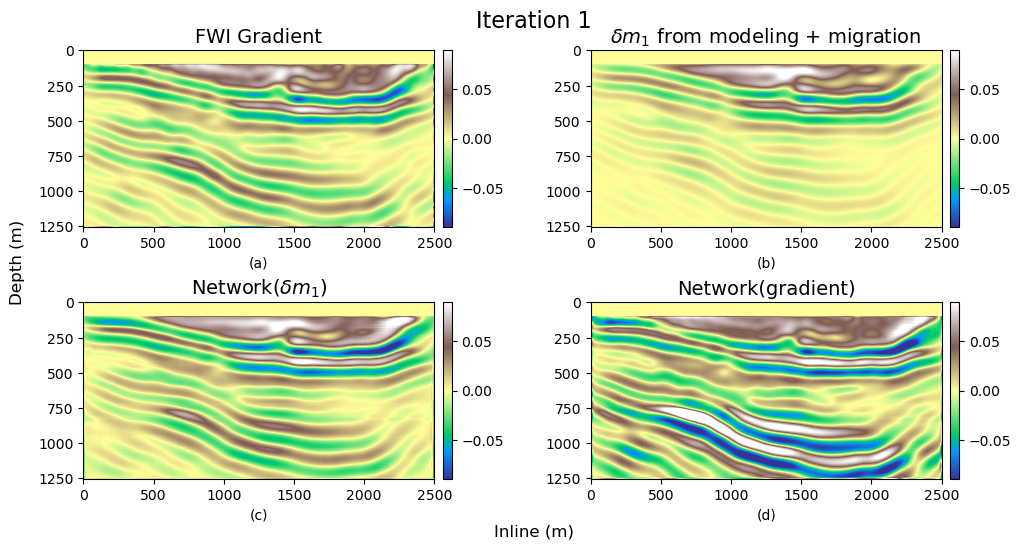

In [15]:
plot_results(gradients, dm1s, gradients_network, dms, iteration=0, save_path=None)

Text(0.5, 1.0, 'Updated Model')

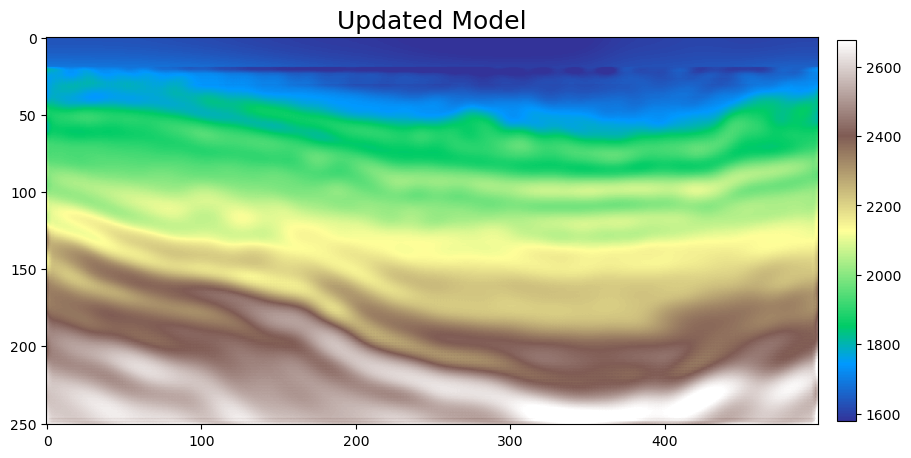

In [16]:
plt.figure(figsize=(12,8))
dm_vmin, dm_vmax = np.percentile(model_true, [2,98])
plt.imshow(updates[-1], vmin=dm_vmin, vmax=dm_vmax, cmap='terrain')
plt.colorbar(shrink=0.62, pad=0.02)
plt.title('Updated Model', fontsize=18)

Text(0.5, 0, 'WE solved')

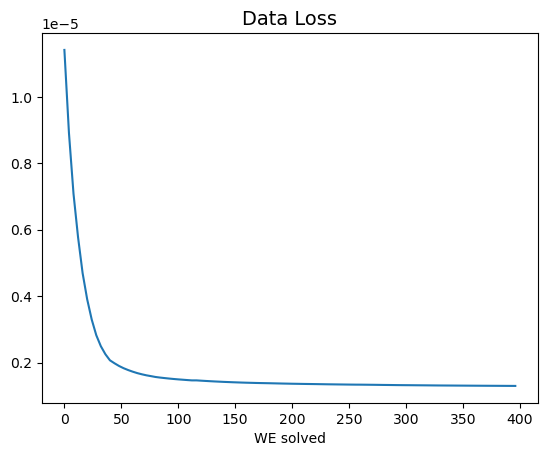

In [17]:
# Plot the data loss per number of wave equation solved 
plt.plot(np.arange(0, 400, 4), data_loss)
plt.title('Data Loss', fontsize=14)
plt.xlabel('WE solved')

Text(0.5, 0, 'WE solved')

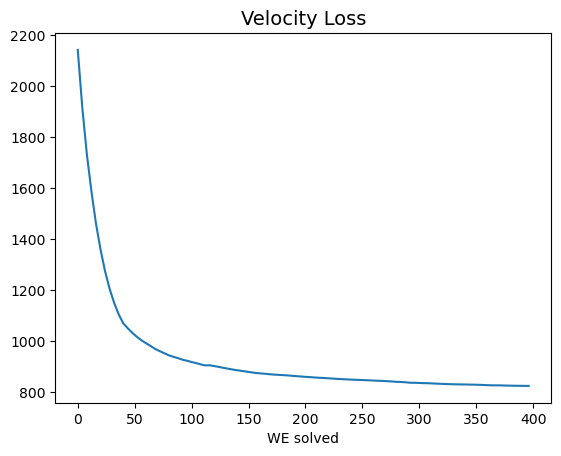

In [18]:
# Plot the velocity loss per number of wave equation solved 
plt.plot(np.arange(0, 400, 4), vel_loss)
plt.title('Velocity Loss', fontsize=14)
plt.xlabel('WE solved')